In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '../')

In [2]:
import torch

import sys
import json
import pickle
from collections import OrderedDict

from attrdict import AttrDict
from tqdm import tqdm_notebook as tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt

from model import RN
from utils import build_dictionaries, collate_samples_from_pixels
from train import initialize_dataset
from viz.IntermediateLayerGetter import IntermediateLayerGetter

In [3]:
with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']

In [4]:
# dictionaries = build_dictionaries('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/')

In [5]:
with open('viz/CLEVR_built_dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)

In [6]:
len(dictionaries[0]), len(dictionaries[1])

(82, 28)

In [7]:
args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

In [8]:
train, val = initialize_dataset(
    clevr_dir='/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
    dictionaries=dictionaries,
    state_description=False,
    sub_set=1,
)

==> using cached questions: questions/CLEVR_train_questions.pkl
==> using cached questions: questions/CLEVR_val_questions.pkl


In [9]:
len(train), len(val)

(699989, 149991)

In [12]:
qtypes = np.unique([q['program'][-1]['function'] for q in val.questions])

In [13]:
indexes_per_qtype = {
    qtype: [index for index, q in enumerate(val.questions) if q['program'][-1]['function'] == qtype] for qtype in tqdm(qtypes)
}

In [14]:
[len(idxs) for idxs in indexes_per_qtype.values()], sum([len(idxs) for idxs in indexes_per_qtype.values()])

([35422,
  6667,
  3447,
  6898,
  6791,
  6742,
  20196,
  4993,
  5101,
  13544,
  13404,
  13273,
  13513],
 149991)

In [15]:
from torch.utils.data import DataLoader, Subset

In [16]:
datasets_per_qtype = {
    qtype: Subset(val, idxs) for qtype, idxs in indexes_per_qtype.items()
}

In [17]:
N_SAMPLES = 2000
selected_idxs_per_qtype = {
    qtype: np.sort(
        np.random.choice(np.arange(0, len(ds)), size=N_SAMPLES, replace=False)).tolist()
    for qtype, ds in datasets_per_qtype.items()
}

In [18]:
# with open('viz/selected_idxs_per_qtype.json', 'w') as f:
#     json.dump(selected_idxs_per_qtype, f)

In [19]:
with open('viz/selected_idxs_per_qtype.json', 'r') as f:
    selected_idxs_per_qtype = json.load(f)

In [20]:
selected_datasets_per_qtype = {
    qtype: Subset(ds, selected_idxs_per_qtype[qtype]) for qtype, ds in datasets_per_qtype.items()
}

In [21]:
[len(idxs) for idxs in selected_datasets_per_qtype.values()], sum([len(idxs) for idxs in selected_datasets_per_qtype.values()])

([2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000,
  2000],
 26000)

In [ ]:
def stretch_tensor(t, size=256):
    if t.size(-1) == size:
        return t
    
    new_t = torch.ones(t.size(0), size, dtype=t.dtype)
    n_reps = size // t.size(-1)
    padding = (size % t.size(-1)) // 2
    
    for i, val in enumerate(t.t()):
        new_t[:, padding + i * n_reps: padding + (i + 1) * n_reps] = val.unsqueeze(-1).expand(t.size(0), n_reps)
        
    return new_t

return_layers = {
    'rl.mha_fc1': 'mha_fc1',
    'rl.mha_fc2': 'mha_fc2',
    'rl.mha_fc3': 'mha_fc3',
    'rl.identity_fc1': 'identity_fc1',
    'rl.identity_fc2': 'identity_fc2',
    'rl.identity_fc3': 'identity_fc3',
    
    'rl.mha_layers.0': 'mha_gc0',
    'rl.mha_layers.1': 'mha_gc1',
    'rl.mha_layers.2': 'mha_gc2',
    'rl.mha_layers.3': 'mha_gc3',
    'rl.identity_layers.0': 'identity_gc0',
    'rl.identity_layers.1': 'identity_gc1',
    'rl.identity_layers.2': 'identity_gc2',
    'rl.identity_layers.3': 'identity_gc3',
}

def make_res_dict():
    return OrderedDict(
        identity_gc0=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc1=torch.empty(0, 256, dtype=torch.float32),
        identity_gc1=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc2=torch.empty(0, 256, dtype=torch.float32),
        identity_gc2=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_gc3=torch.empty(0, 256, dtype=torch.float32),
        identity_gc3=torch.empty(0, 64, 64, 256, dtype=torch.float32),

        mha_fc1=torch.empty(0, 256, dtype=torch.float32),
        identity_fc1=torch.empty(0, 256, dtype=torch.float32),

        mha_fc2=torch.empty(0, 256, dtype=torch.float32),
        identity_fc2=torch.empty(0, 256, dtype=torch.float32),

        mha_fc3=torch.empty(0, 28, dtype=torch.float32),
        identity_fc3=torch.empty(0, 28, dtype=torch.float32),
    )

g_keys = [
    'identity_gc0',
    'mha_gc1',
    'identity_gc1',
    'mha_gc2',
    'identity_gc2',
    'mha_gc3',
    'identity_gc3',
]
f_keys = [
    'mha_fc1',
    'identity_fc1',
    'mha_fc2',
    'identity_fc2',
    'mha_fc3',
    'identity_fc3'
]

mha_keys = [
    'mha_gc1',
    'mha_gc2',
    'mha_gc3',
    'mha_fc1',
    'mha_fc2',
    'mha_fc3',

]

identity_keys = [
    'identity_gc0',
    'identity_gc1',
    'identity_gc2',
    'identity_gc3',
    'identity_fc1',
    'identity_fc2',
    'identity_fc3',
]

import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_masks(masks):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)

    norm = colors.LogNorm()
    for i, (qtype, im) in enumerate(masks.items()):
        ax = axes[i // 7][i % 7]
        img = ax.imshow(
            im.detach().numpy().T,
            aspect='auto',
            cmap='Greys_r',
            norm=norm,
            # vmin=0, vmax=1,
            # vmin=1e-5, vmax=1
        )
        ax.set_title(qtype)
        ax.set_yticks([64 * i for i in range(4)])
        # ax.set_xticks(list(range(6)))
        ax.set_xticks(tuple())
        # ax.set_xticklabels(['g_fc1', 'g_fc2', 'g_fc3', 'f_fc1', 'f_fc2', 'f_fc3'], rotation='vertical')
    
    cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat[::-1]], aspect=75)
    cbar = plt.colorbar(img, cax=cax, aspect=1, **kw)

    axes[-1, -1].axis('off')
    plt.show()

In [83]:
model = RN(args=args, hyp=hyp)
# model = torch.nn.DataParallel(rn)
model.load_state_dict(torch.load('best_weights/l1_01.pth', map_location='cpu'))
# model = model.module

# dat = collate_samples_from_pixels([train[5]])
# q = model.module.text(dat['question'])
# weights = model.module.rl.g_layers[1]
# model.module.rl.mha_layers[1](q.unsqueeze(1), weights.weight, weights.weight)
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=False)

Supposing original DeepMind model


In [84]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [85]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

In [86]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

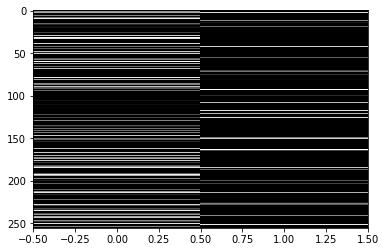

In [87]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

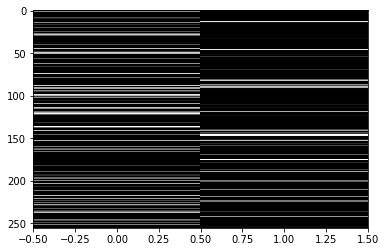

In [88]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [89]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

In [ ]:
all_res = {}
for qtype in tqdm(qtypes):
    res = make_res_dict()

    with torch.no_grad():
        model.eval()
        for i, b in tqdm(enumerate(loader), total=len(loader)):
            model.coord_tensor = None
            mid_res, _ = mid_getter(b['image'], b['question'])

            for k in mha_keys:
                res[k] = torch.cat((res[k], mid_res[k][1].squeeze(1)))

            for k in identity_keys:
                if 'gc' in k:
                    res[k] = torch.cat((res[k], mid_res[k].view(-1, 64, 64, 256)))
                else:
                    res[k] = torch.cat((res[k], mid_res[k]))

            if i == 2:
                break

    all_res[qtype] = res

In [79]:
formatted_res = {}

for qtype, qres in all_res.items():
    mask = torch.empty(0, 256, dtype=torch.float32)
    for k in mha_keys[:-1]:
        mask = torch.cat((mask, qres[k].mean(dim=0).unsqueeze(0)), dim=0)
    formatted_res[qtype] = mask

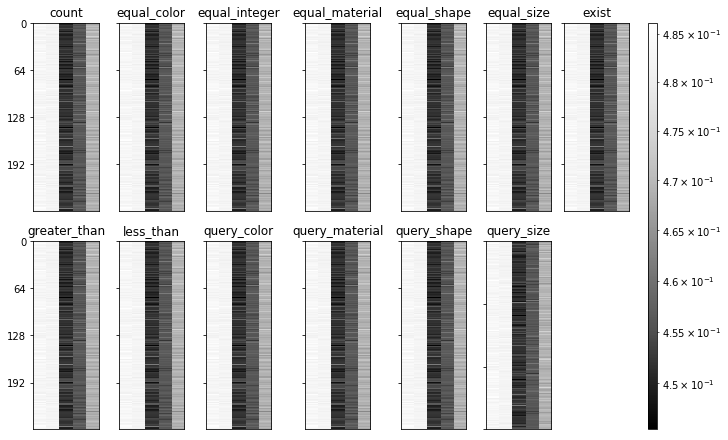

In [80]:
plot_masks(formatted_res)

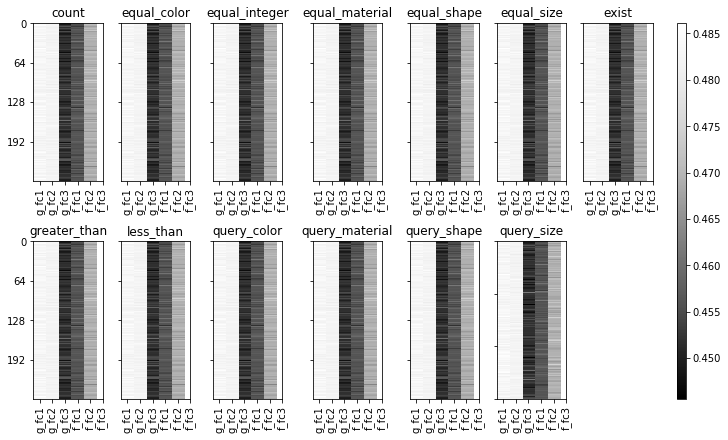

In [81]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 6), sharey=True, constrained_layout=True)

norm = colors.LogNorm()
for i, (qtype, results) in enumerate(all_res.items()):
    ax = axes[i // 7][i % 7]
    img = ax.imshow(
        np.array([stretch_tensor(results[k]).mean(dim=0).numpy() for k in mha_keys[:-1]]).T,
        aspect='auto',
        cmap='Greys_r',
        # norm=norm,
        # vmin=0, vmax=1,
        # vmin=1e-5, vmax=1
    )
    ax.set_title(qtype)
    ax.set_yticks([64 * i for i in range(4)])
    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(['g_fc1', 'g_fc2', 'g_fc3', 'f_fc1', 'f_fc2', 'f_fc3'], rotation='vertical')
    
cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat[::-1]], aspect=75)
cbar = plt.colorbar(img, cax=cax, aspect=1, **kw)

axes[-1, -1].axis('off')
# plt.tight_layout()
# plt.axis('off')
plt.show()

In [82]:
all_res['count']['mha_gc1'].std(dim=0)

tensor([0.0096, 0.0089, 0.0088, 0.0094, 0.0085, 0.0104, 0.0097, 0.0099, 0.0089,
        0.0103, 0.0098, 0.0105, 0.0097, 0.0092, 0.0104, 0.0100, 0.0095, 0.0096,
        0.0088, 0.0101, 0.0108, 0.0092, 0.0098, 0.0104, 0.0095, 0.0086, 0.0102,
        0.0102, 0.0101, 0.0106, 0.0096, 0.0093, 0.0098, 0.0092, 0.0091, 0.0097,
        0.0096, 0.0093, 0.0100, 0.0106, 0.0093, 0.0081, 0.0096, 0.0095, 0.0092,
        0.0096, 0.0094, 0.0101, 0.0090, 0.0092, 0.0095, 0.0096, 0.0093, 0.0103,
        0.0105, 0.0101, 0.0094, 0.0092, 0.0105, 0.0090, 0.0093, 0.0104, 0.0090,
        0.0095, 0.0090, 0.0098, 0.0089, 0.0101, 0.0099, 0.0096, 0.0098, 0.0108,
        0.0095, 0.0099, 0.0103, 0.0107, 0.0097, 0.0106, 0.0088, 0.0100, 0.0098,
        0.0099, 0.0097, 0.0091, 0.0089, 0.0099, 0.0092, 0.0094, 0.0091, 0.0099,
        0.0098, 0.0097, 0.0080, 0.0104, 0.0091, 0.0098, 0.0096, 0.0099, 0.0104,
        0.0097, 0.0102, 0.0090, 0.0099, 0.0096, 0.0103, 0.0092, 0.0095, 0.0105,
        0.0086, 0.0104, 0.0108, 0.0096, 